In [1]:
import os
import sys
import h5py
import pandas as pd
import numpy as np
import tqdm
import pickle
import copy
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.stats as ss
import seaborn as sns
import keras
import scipy
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K    
from sklearn.metrics import roc_auc_score as auroc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

### Load multi-scale footprint and TF binding data

In [2]:
np.random.seed(123)

In [3]:
hf = h5py.File("../../data/yeast/nucDataCRE.h5", 'r')

# Multi-scale footprint scores for each TF motif site
# Here we use footprints calculated using 6 different window sizes:
# 10bp, 20bp, 30bp, 50bp, 80bp (radius, not diameter)
# For each window radius, we take a 201 bp (+/- 100bp with the motif center 1bp) local neighborhood 
# as model input. Therefore for each locus we have a 201 * 5 = 1005 dimensional vector as input
# If we have in total N data points, then hf['footprints'] should be a N-by-1005 matrix
footprints = hf['footprints']
footprints = np.transpose(np.array(footprints))

# Remove infinite values
footprints[~np.isfinite(footprints)] = 0

# Get nucleosome chemical mapping data
nuc_labels = np.array(hf['nucLabel'])
nuc_signal = np.array([i[0] for i in nuc_labels])
chromosome = np.array([i[1].decode("ascii") for i in nuc_labels])
coverage = np.array([i[2] for i in nuc_labels])
scales = np.array(hf['scales'])

In [4]:
np.shape(chromosome)

(590844,)

In [5]:
# Remove data with zero signal
sig_filter = coverage > 10
footprints = footprints[sig_filter, :]
nuc_signal = nuc_signal[sig_filter]
chromosome = chromosome[sig_filter]

In [6]:
# Scale the features 
footprint_mean = np.mean(footprints, axis = 0)
footprint_sd = np.std(footprints, axis = 0)
footprints = (footprints - footprint_mean) / footprint_sd

In [7]:
# Scale the target values
nuc_signal_rescaled = (nuc_signal - np.percentile(nuc_signal, 5)) / \
                        (np.percentile(nuc_signal, 95) - np.percentile(nuc_signal, 5))

### Preparing data for model training, optimization and evaluation

In [8]:
# Split all chromosomes into training, validation, and test
chrs = np.unique(chromosome)
chrs = np.delete(chrs, np.where(chrs == "chrM"))
np.random.shuffle(chrs)
nchrs = len(chrs)
training_chrs = chrs[:8]
val_chrs = chrs[8:10]
test_chrs = chrs[10:]
print("Training chromosomes: " + ", ".join(training_chrs))
print("Val chromosomes: " + ", ".join(val_chrs))
print("Test chromosomes: " + ", ".join(test_chrs))

# Partition data by chromosome
training_inds = np.array([i for i in range(len(chromosome)) if chromosome[i] in training_chrs])
val_inds = np.array([i for i in range(len(chromosome)) if chromosome[i] in val_chrs])
test_inds = np.array([i for i in range(len(chromosome)) if chromosome[i] in test_chrs])
print("Training data: " + str(len(training_inds)))
print("Val data: " + str(len(val_inds)))
print("Test data: " + str(len(test_inds)))

# Shuffle order of data
np.random.shuffle(training_inds)
np.random.shuffle(val_inds)
np.random.shuffle(test_inds)

# Get training data
training_data = footprints[training_inds, :]
training_target = nuc_signal_rescaled[training_inds]

# Get validation data
val_data = footprints[val_inds, :]
val_target = nuc_signal_rescaled[val_inds]

# Get test data
test_data = footprints[test_inds, :]
test_target = nuc_signal_rescaled[test_inds]

Training chromosomes: chrVII, chrXI, chrIX, chrI, chrV, chrX, chrVIII, chrXII
Val chromosomes: chrIV, chrII
Test chromosomes: chrVI, chrXVI, chrXIII, chrIII, chrXIV, chrXV
Training data: 261032
Val data: 113917
Test data: 212791


### Model training

In [9]:
def model_training(training_data, training_target, val_data, val_target):
    
    # Initialize a Keras model for footprint-to-TF binding prediction
    inputs = Input(shape = np.shape(training_data)[1])
    fc_1 = Dense(64, activation = "relu")(inputs)
    fc_2 = Dense(16, activation = "relu")(fc_1)
    output = Dense(1, activation = "linear")(fc_2)
    model = keras.models.Model(inputs, output)
    model.summary()
    model.compile(optimizer = "adam",
                  loss='mse', metrics=['mse'])
    loss = tf.keras.losses.MeanSquaredError()
    prev_loss = np.inf

    # Model training
    for n_epoch in range(10):

        # New training epoch
        model.fit(training_data, training_target, 
                  batch_size = 128, epochs = 1, 
                  validation_data = (val_data, val_target)) 

        # Calculate loss on validation set
        val_pred = np.transpose(model.predict(val_data))[0]
        mse_loss = loss(val_target, val_pred).numpy()

        # If loss on validation set stops decreasing rapidly, stop training and adopt the previous saved version
        if mse_loss - prev_loss > -0.001:
            break
        else:
            prev_loss = mse_loss

            # Save current model version
            model.save("../../data/yeast/nucleosome_model.h5")

    # Load the last Tn5 bias model
    model = load_model("../../data/yeast/nucleosome_model.h5")
    
    return model

In [10]:
model = model_training(training_data, training_target, 
                       val_data, val_target)

2023-03-30 11:16:42.313782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/cudnn/8.1.0.77_cuda11.2-fasrc01/lib64
2023-03-30 11:16:42.313826: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 11:16:42.313850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (holy7c26410.rc.fas.harvard.edu): /proc/driver/nvidia/version does not exist
2023-03-30 11:16:42.314185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneD

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1005)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                64384     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 65,441
Trainable params: 65,441
Non-trainable params: 0
_________________________________________________________________


2023-03-30 11:16:50.588721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2040/2040 [==============================] - 6s 3ms/step - loss: 0.1561 - mse: 0.1561 - val_loss: 0.0789 - val_mse: 0.0789


/tmp/ipykernel_22432/2760569521.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(test_target, test_pred, s = 0.01, vmax = 0.5, vmin = -0.5)


SignificanceResult(statistic=0.5946148119345341, pvalue=0.0)

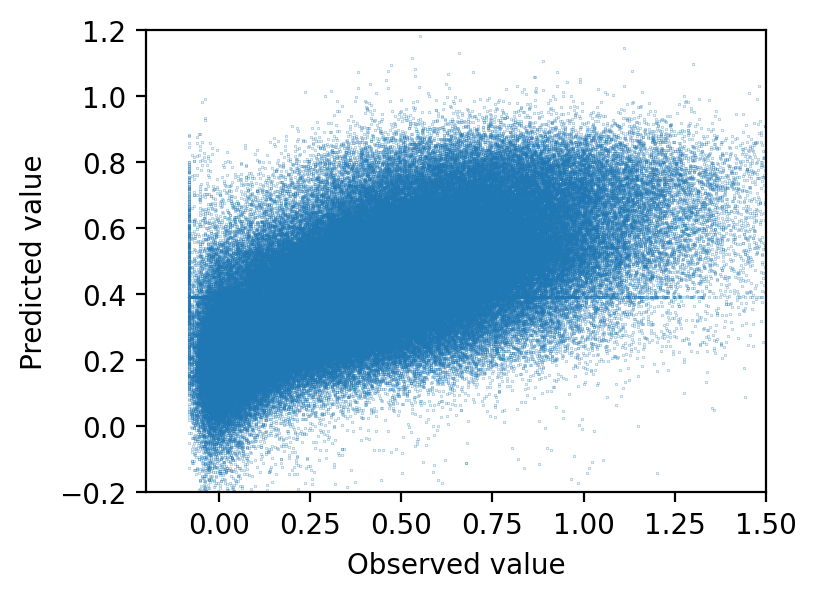

In [11]:
test_pred = model.predict(test_data)[:, 0]
plt.figure(dpi = 200, figsize = (4,3))
plt.scatter(test_target, test_pred, s = 0.01, vmax = 0.5, vmin = -0.5)
plt.axis([-0.2, 1.5, -0.2, 1.2])
plt.xlabel("Observed value")
plt.ylabel("Predicted value")
ss.spearmanr(test_target, test_pred)

In [12]:
# Save the rescaling factor for later use
with h5py.File("../../data/yeast/nucleosome_model.h5", "a") as hf:
    hf["footprint_mean"] = footprint_mean
    hf["footprint_sd"] = footprint_mean
    hf["scales"] = scales

### Calculate and visualize gradients with respect to input

In [13]:
# Get model gradients with respect to input
# Helps to visualize what the model has learned
def get_gradients(model, data):
    
    # Calculate gradients with respect to the input
    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    print(np.shape(model(data_tensor)))
    with tf.GradientTape() as t:
        t.watch(data_tensor)
        tape_output = model(data_tensor)[:, 0]
    gradients = t.gradient(tape_output, data_tensor)

    # Smoothe gradients
    from scipy.signal import savgol_filter
    smoothed_grad = savgol_filter(np.median(gradients, axis = 0), 51, 3) 
    # window size 51, polynomial order 3
    # np.median(gradients, axis = 0)[:-1] removes the last value which is gradient for motif match score
    # We are now only interested in gradients with respect to footprint patterns

    return smoothed_grad

(10000, 1)


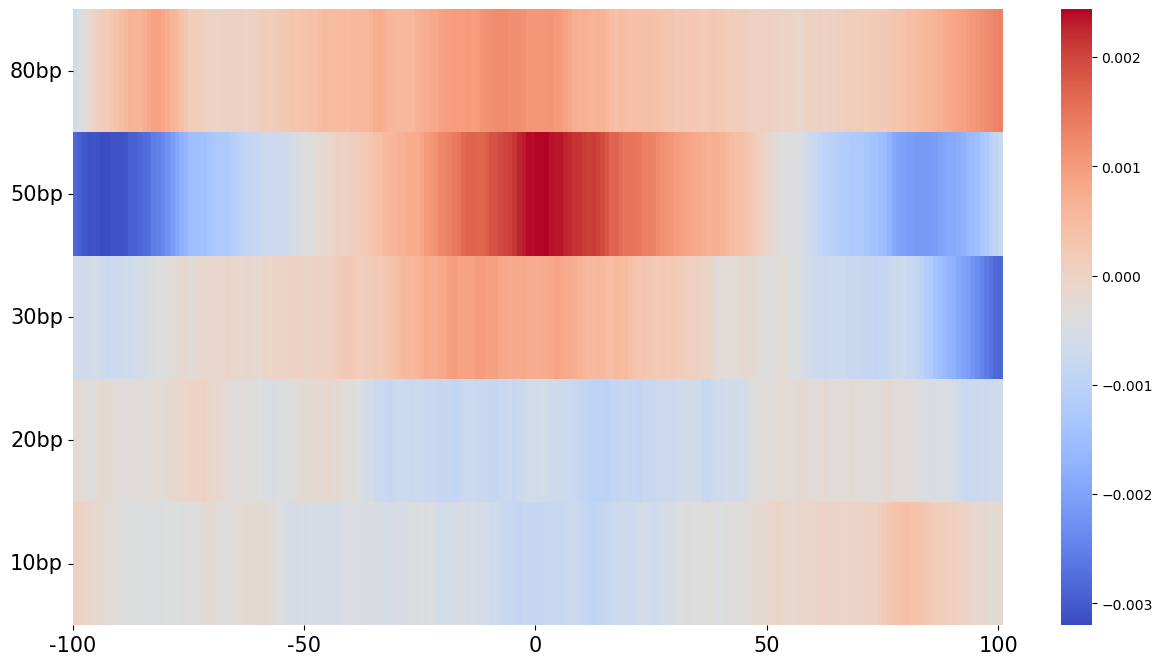

In [14]:
sample_ind = np.random.choice(np.arange(len(training_target)), 10000)
smoothed_grad = get_gradients(model, training_data[sample_ind, :])

# Visualize the learned greadients
# Note that the scales here represent radius not diameter!
# Diameter should be from 20 bp to 200 bp
smoothed_grad = np.flip(np.reshape(smoothed_grad, (5, -1)), axis = 0)
plt.figure(figsize = (15,8))
ax = sns.heatmap(smoothed_grad, 
            yticklabels=["80bp", "50bp", "30bp", "20bp", "10bp",], 
            xticklabels=False, 
            cmap = sns.color_palette("coolwarm", as_cmap=True))
plt.xticks(np.arange(0,250,50))
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0, fontsize = 15)
ax.set_xticklabels(np.arange(0,250,50) - 100, fontsize = 15)
plt.show()